# Trawl Processes
This notebook demonstrates how to work with the **Gaussian** and **Gamma** trawl processes
We will:
* define an exponential trawl kernel,
* evaluate the marginal density,
* compute a characteristic function / cumulant at a single time,
* draw and plot a few sample trajectories.

In [1]:
import matplotlib.pyplot as plt
import torch

from ambitsinn import GammaTrawlProcess, GaussianTrawlProcess

rng = torch.Generator().manual_seed(0)

Let's define exponential trawl function

In [2]:
lambda_ = 0.5


def exp_integrated_trawl(s: torch.Tensor) -> torch.Tensor:
    """Exponential integrated trawl function G(s) = exp(-λ s) / λ."""
    return torch.exp(-lambda_ * s) / lambda_

## Gaussian exponential-trawl process (OU-process)

In [3]:
gauss = GaussianTrawlProcess(
    integrated_trawl_function=exp_integrated_trawl,
    mean=0.0,  # marginal mean = 0
    var=1.0,  # marginal variance = 1
    theta_batch_first=True,
    arg_check=True,
)

# Observation grid (you can pick any increasing vector you like)
times = torch.linspace(0.0, 10.0, steps=201)  # 201 points, Δt ≈ 0.05

Marginal density:

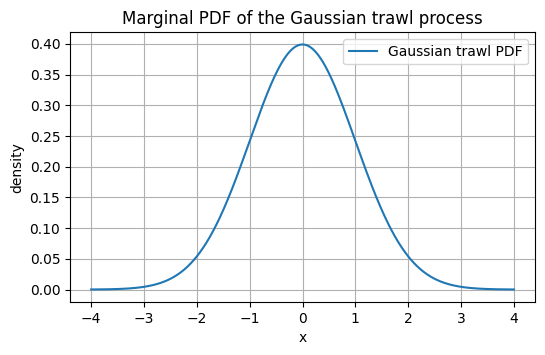

In [4]:
x_vals = torch.linspace(-4.0, 4.0, steps=400)
pdf_vals = gauss.pdf(x_vals)  # shape (400,)

plt.figure(figsize=(6, 3.5))
plt.plot(x_vals.numpy(), pdf_vals.numpy(), label="Gaussian trawl PDF")
plt.title("Marginal PDF of the Gaussian trawl process")
plt.xlabel("x")
plt.ylabel("density")
plt.grid(True)
plt.legend()
plt.show()

Evaluation of cumulant and characteristic function:

In [5]:
t0 = torch.tensor([5.0])  # shape (1,)

# Fourier argument – a scalar u (here we pick u = 1.2)
u = 1.2
theta = torch.tensor([[u]])  # shape (1, D) because D=1

# Characteristic function φ(u) = exp( κ(u) )
phi = gauss.charfunc(theta, t0)  # complex tensor, shape (1,)
kappa = gauss.cumulant(theta, t0)  # shape (1,)

print(f"θ = {u:.3f}")
print(f"Cumulant κ(θ)  = {kappa.item():.6f}  (real)  # mean=0 ⇒ no imaginary part")
print(f"Characteristic function φ(θ) = {phi.item():.6f}")

θ = 1.200
Cumulant κ(θ)  = -0.720000+0.000000j  (real)  # mean=0 ⇒ no imaginary part
Characteristic function φ(θ) = 0.486752+0.000000j


Marginal cumulant:

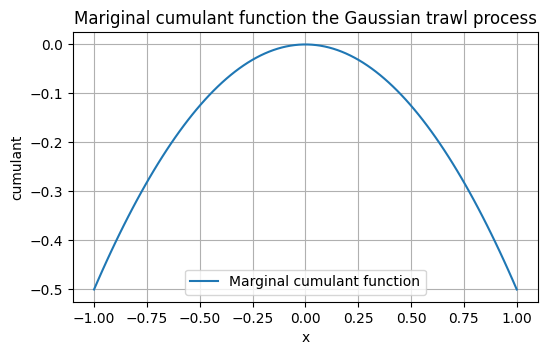

In [6]:
theta = torch.linspace(-1.0, 1.0, 100).view(100, 1)
kappa = gauss.cumulant(theta, t0)  # shape (1,)

plt.figure(figsize=(6, 3.5))
plt.plot(theta.numpy(), kappa.real.numpy(), label="Marginal cumulant function")
plt.title("Mariginal cumulant function the Gaussian trawl process")
plt.xlabel("x")
plt.ylabel("cumulant")
plt.grid(True)
plt.legend()
plt.show()

Autocorrelation:

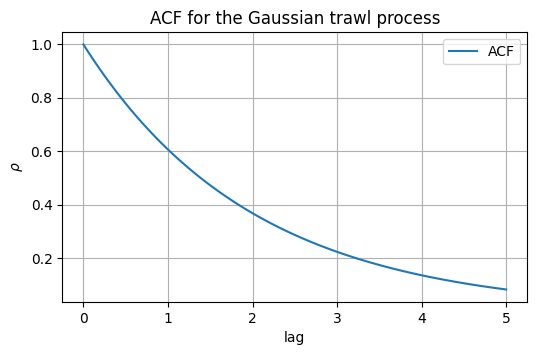

In [7]:
lags = torch.linspace(0.0, 5.0, 100)
acf = gauss.acf(lags)  # shape (1,)

plt.figure(figsize=(6, 3.5))
plt.plot(lags.numpy(), acf.real.numpy(), label="ACF")
plt.title("ACF for the Gaussian trawl process")
plt.xlabel("lag")
plt.ylabel("$\\rho$")
plt.grid(True)
plt.legend()
plt.show()

Sampling:

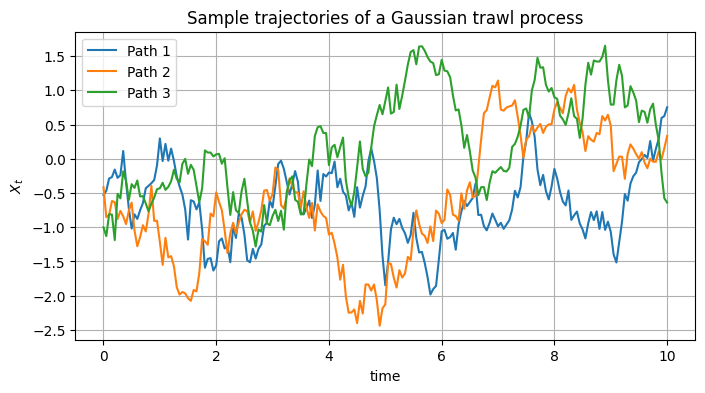

In [8]:
samples = gauss.sample(
    times,
    rng=rng,
    batch_size=3,  # number of independent trajectories
    batch_first=True,
    unsqueeze_last=True,
)  # shape (3, len(times), 1)

samples = samples.squeeze(-1).cpu().numpy()  # shape (3, len(times))

plt.figure(figsize=(8, 4))
for i, path in enumerate(samples):
    plt.plot(times.numpy(), path, label=f"Path {i + 1}")
plt.title("Sample trajectories of a Gaussian trawl process")
plt.xlabel("time")
plt.ylabel("$X_t$")
plt.grid(True)
plt.legend()
plt.show()

Or, we can create finite-dimensional distribution and sample from it:

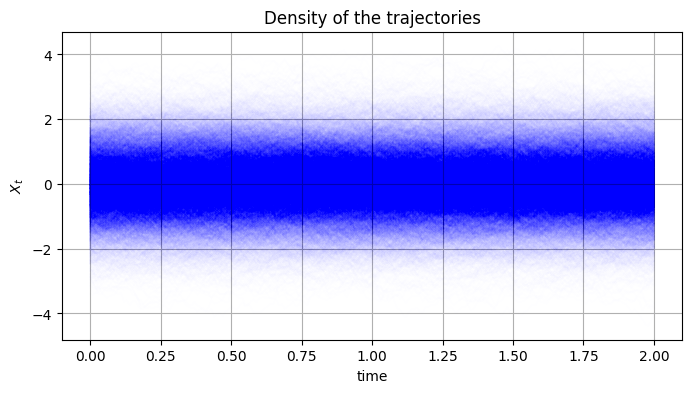

In [9]:
times = torch.linspace(0.0, 2.0, steps=201)
fdd = gauss.at_times(times)
data = fdd.sample(batch_size=10000, unsqueeze_last=False, batch_first=True)
plt.figure(figsize=(8, 4))
plt.plot(times.numpy(), data.numpy().T, color="blue", alpha=0.005)
plt.title("Density of the trajectories")
plt.xlabel("time")
plt.ylabel("$X_t$")
plt.grid(True)
plt.show()

## Gamma exponential-trawl process with positive, skewed marginal
Now we repeat the same steps for a **Gamma** trawl.  
We choose marginal shape = 2.0 and rate = 3.0 (so the mean is 2/3 ≈ 0.667).

In [10]:
gamma = GammaTrawlProcess(
    integrated_trawl_function=exp_integrated_trawl,
    shape=2.0,  # marginal shape α
    rate=3.0,  # marginal rate β
    theta_batch_first=True,
    arg_check=True,
)

# Re‑use the same observation grid as before
times = torch.linspace(0.0, 10.0, steps=201)  # 201 points, Δt ≈ 0.05

Marginal PDF (Gamma is only defined on x>0):

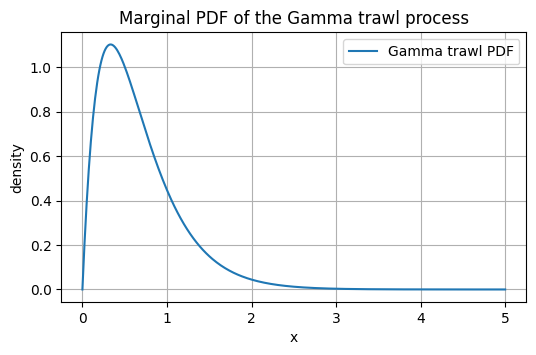

In [11]:
x_vals_g = torch.linspace(0.0, 5.0, steps=401)
pdf_vals_g = gamma.pdf(x_vals_g)

plt.figure(figsize=(6, 3.5))
plt.plot(x_vals_g.numpy(), pdf_vals_g.numpy(), label="Gamma trawl PDF")
plt.title("Marginal PDF of the Gamma trawl process")
plt.xlabel("x")
plt.ylabel("density")
plt.grid(True)
plt.legend()
plt.show()

Characteristic function & cumulant at a three times:

In [12]:
t0_g = torch.tensor([0.0, 1.0, 2.0])
fdd_example = gamma.at_times(t0_g)
theta_g = torch.tensor([[0.8, 2.0, 3.0]])
phi_g = fdd_example.charfunc(theta_g)
kappa_g = fdd_example.cumulant(theta_g)

print(f"θ = {theta_g}")
print(f"Cumulant κ(θ)  = {kappa_g.item():.6f}  (complex)")
print(f"Characteristic function φ(θ) = {phi_g.item():.6f}")

θ = tensor([[0.8000, 2.0000, 3.0000]])
Cumulant κ(θ)  = -1.395677+2.659943j  (complex)
Characteristic function φ(θ) = -0.219489+0.114729j


Sample trajectories for the Gamma trawl:

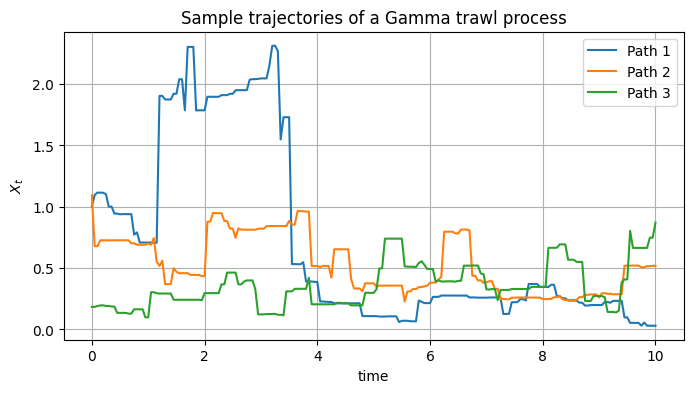

In [13]:
fdd = gamma.at_times(times)
samples = fdd.sample(batch_size=3, batch_first=True)
samples = samples.squeeze(-1).cpu().numpy()  # shape (3, len(times))

plt.figure(figsize=(8, 4))
for i, path in enumerate(samples):
    plt.plot(times.numpy(), path, label=f"Path {i + 1}")
plt.title("Sample trajectories of a Gamma trawl process")
plt.xlabel("time")
plt.ylabel("$X_t$")
plt.grid(True)
plt.legend()
plt.show()